# Pokemon Dataset - Predicting Legendaries


The goal of this notebook is to create a supervised machine learning classifier that can predict whether a Pokemon is legendary based on its statistics.

## Importing Modules and Data

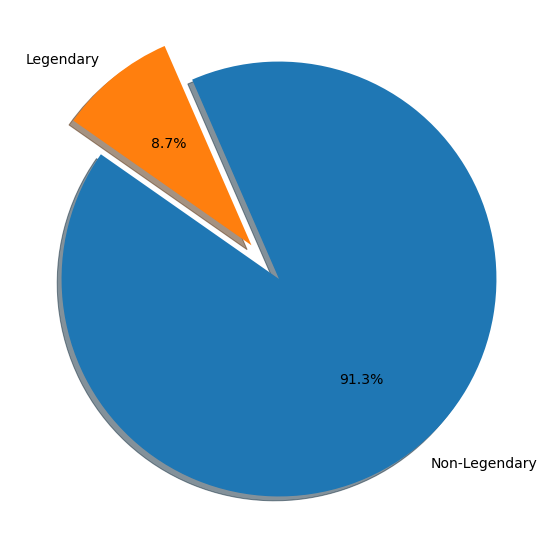

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from pokedex import pokedex
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler      
from sklearn.pipeline import Pipeline  
from sklearn.svm import SVC
from matplotlib.patches import Patch
from sklearn.metrics import precision_score, recall_score, f1_score
from pandas.api.types import CategoricalDtype

df = pd.read_csv('pokemon.csv')

fig = plt.figure(figsize=(10,10))

legendary_counts = np.unique(df['is_legendary'], return_counts=True)[1]

plt.pie(legendary_counts,labels=['Non-Legendary', 'Legendary'], 
    autopct ='%1.1f%%', 
    shadow = True,                 
    startangle = 145,
    explode=(0, 0.2),
    textprops={'fontsize': 14}
)

plt.show()

display(df.head())


## Feature Description

### Unique Identifiers
- `pokedex_number`: The index of the Pokemon in the Pokedex
- `name`: The name of the Pokemon in English
- `japanese_name`: The name of the Pokemon in Japanese

### Categorical Features
- `abilities`: A list of Pokemon's attacks/abilities
- `classification`: The classification of the Pokemon (Bird Pokemon, Seed Pokemon etc. )
- `type1`: The primary type of the Pokemon (fire, water, flying, electric)
- `type2`: The secondary type of the Pokemon
- `generation`: The generation in which the Pokemon was introduced
- `is_legendary`: indicates whether the Pokemon is legendary

### Numerical Features
- `against_{type}`: 18 features that denote the incoming damage multiplier from Pokemon of type {type}
- `attack`: The attack damage of the Pokemon
- `base_egg_steps`: # of steps required to hatch an egg of the Pokemon
- `base_happiness`: The base happiness of the Pokemon
- `base_total`: hp + attack + defense + speed + sp_attack + sp_defense
- `capture_rate`: The base capture rate of the Pokemon (presumably with a regular Pokeball?)
- `defense`: The defense of the Pokemon
- `experience_growth`: The experience growth of the Pokemon
- `height_m`: The height of the Pokemon in metres
- `hp`: The total health (hit points/health points) of the Pokemon
- `percentage_male`: The percentage of the species that are male.
- `sp_attack`: The special attack damage
- `sp_defense`: The special defense 
- `speed`: The Pokemon's speed
- `weight_kg`: The weight of the Pokemon in kilograms

## Pre-processing and Exploratory Data Analysis

Let's start by double-checking base_total and searching for missing data.

In [4]:
#  check that base_total = hp + attack + defense + speed + sp_attack + sp_defense
print((df.loc[:,['attack','defense','hp','speed','sp_attack','sp_defense']].apply(lambda x: x.sum(), axis=1) == df['base_total']).all())

# check for null values
display(df.info())

True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       80

None

Notice that `height_m` and `weight_kg` contain several missing values. Luckily, this data is available via the Pokemon API wrapper library: 

- https://github.com/PokeDevs/pokedex.py. 


The weights and heights supplied by the API are given in imperial units. The function below handles the conversion to SI units and is used to fill the missing values.

In [3]:
def get_missing_height_weight(number):
    """ 
    A function to query the Pokedex API using the pokedex_number and return the height (m) and weight (kg).
    """
    info = pokedex.Pokedex().get_pokemon_by_number(number)[0]

    height_feet = info['height'].split("\'")[0]
    height_inches = info['height'].split("\'")[1][:-1]
    
    # to account for examples where inches are omitted from the string for being zero e.g. rattata height = 1'
    height_inches = 0 if height_inches == "" else height_inches 
    
    height_meters = (float(height_feet) * 12 + float(height_inches)) * 0.0254

    weight_lbs = info['weight'][:-5]
    weight_kg = float(weight_lbs) / 2.2046
    
    return round(height_meters,1), round(weight_kg,1)

for pokedex_num in df.loc[df['height_m'].isna(), ['pokedex_number']].values:

    print(f"Found missing height/weight for Pokemon {pokedex_num[0]}: {df.loc[df['pokedex_number'] == pokedex_num[0], 'name'].values}")
    df.loc[df['pokedex_number'] == pokedex_num[0], ['height_m', 'weight_kg']] = get_missing_height_weight(pokedex_num[0])


Found missing height/weight for Pokemon 19: ['Rattata']
Found missing height/weight for Pokemon 20: ['Raticate']
Found missing height/weight for Pokemon 26: ['Raichu']
Found missing height/weight for Pokemon 27: ['Sandshrew']
Found missing height/weight for Pokemon 28: ['Sandslash']
Found missing height/weight for Pokemon 37: ['Vulpix']
Found missing height/weight for Pokemon 38: ['Ninetales']
Found missing height/weight for Pokemon 50: ['Diglett']
Found missing height/weight for Pokemon 51: ['Dugtrio']
Found missing height/weight for Pokemon 52: ['Meowth']
Found missing height/weight for Pokemon 53: ['Persian']
Found missing height/weight for Pokemon 74: ['Geodude']
Found missing height/weight for Pokemon 75: ['Graveler']
Found missing height/weight for Pokemon 76: ['Golem']
Found missing height/weight for Pokemon 88: ['Grimer']
Found missing height/weight for Pokemon 89: ['Muk']
Found missing height/weight for Pokemon 103: ['Exeggutor']
Found missing height/weight for Pokemon 105: ['

We see that `type2` contains some missing values too, this is because some Pokemon have no secondary type. In this instance we can simply replace np.nan with the string 'none'. We also note several examples where `type2` is a duplicate of `type1`; these will also be replaced with 'none'.

The `capture_rate` appears to have been imported as an object type, whereas we would expect this to be int64. Further digging reveals that the Pokemon 'Minior' has two capture rates: 30 (Meteorite) and 255 (Core), which are interpretted as string. Based on https://bulbapedia.bulbagarden.net/wiki/Minior_(Pok%C3%A9mon), we will set this to 30 and convert the column to int64.

In [4]:
# fixing secondary type
df.loc[df['type1']==df['type2'],'type2'] = np.nan
df.loc[df['type2'].isna(), 'type2'] = "None"

# fixing capture rate for minior
df.loc[773,'capture_rate'] = 30 
df['capture_rate'] = df['capture_rate'].astype('int64')

The last missing values relate to gender, which on closer inspection seems to be a good indicator of whether a Pokemon is legendary. The calculation below shows that 90% of legendary pokemon have an undefined gender, compared to ~5% of non-legendary. It may be useful to create a new binary feature to indicate whether the Pokemon has a gender.

In [5]:
# check count of missing percentage_male 
df.groupby('is_legendary')['percentage_male'].apply(lambda x: pd.Series({'No. Missing':x.isna().sum(),'Total': len(x)}))

# add new 'has_gender' feature
df['has_gender'] = ~df['percentage_male'].isna()

Now, let's see if there's any obvious relationship between type1, type2, generation and legendary status.

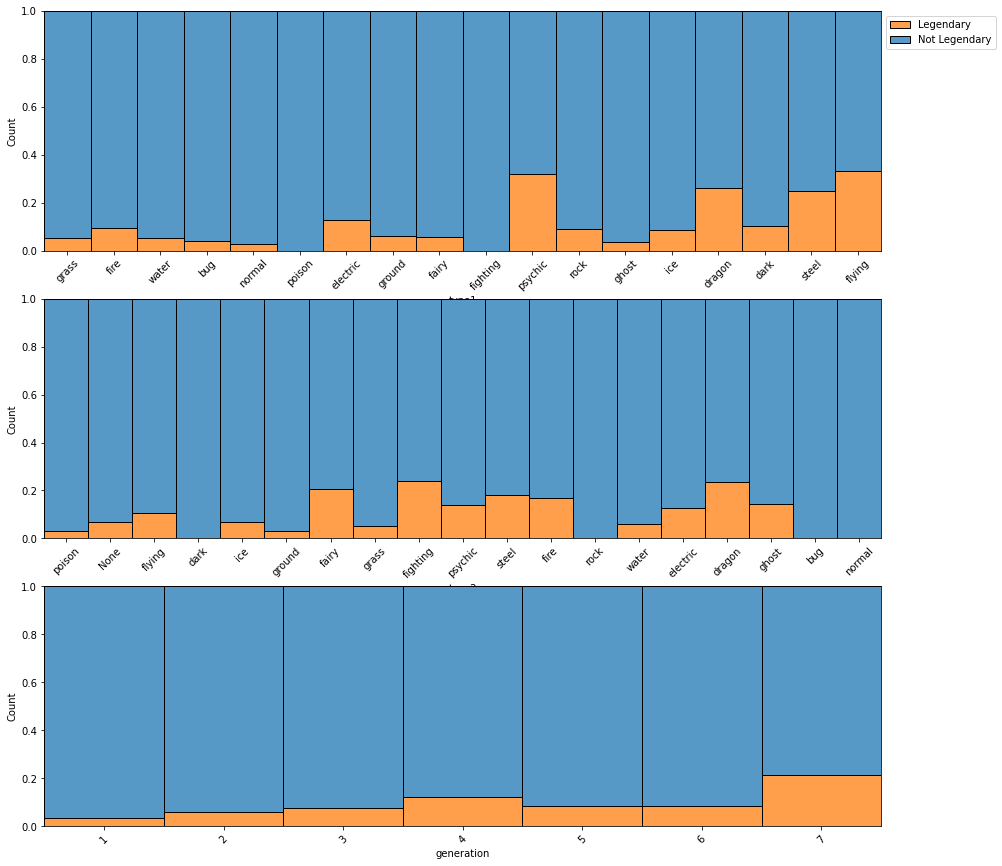

In [6]:
# convert generation to categorical
cat_dtype = CategoricalDtype(categories=[1,2,3,4,5,6,7], ordered=True)
df['generation'] = df['generation'].astype(cat_dtype)

fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(15,15))

for ax, var in zip([ax1, ax2, ax3], ['type1', 'type2', 'generation']): 
    sns.histplot(data=df, x=var, hue='is_legendary', multiple='fill', ax=ax, legend=False)
    plt.setp(ax.get_xticklabels(), rotation=45)

fig.legend(['Legendary', 'Not Legendary'], bbox_to_anchor=(0.9,0.88), loc="upper left")
plt.show()

We see an increased proportion of legendaries amongst the dragon, steel, psychic and flying type Pokemon, but generally they seem to be fairly distributed across all types. In addition, one-hot encoding the type1 and type2 features will increase the dimensionality of the data considerably and will most likely hurt predictive performance. 

There is an increased proportion of legendary Pokemon in generation 7, but again, there is no clear trend across the remaining generations.

Next we will create plots of the numerical features, but omit the `against_{type}` features. This is because they are related to the type of the Pokemon, which we have already identified as not too useful.

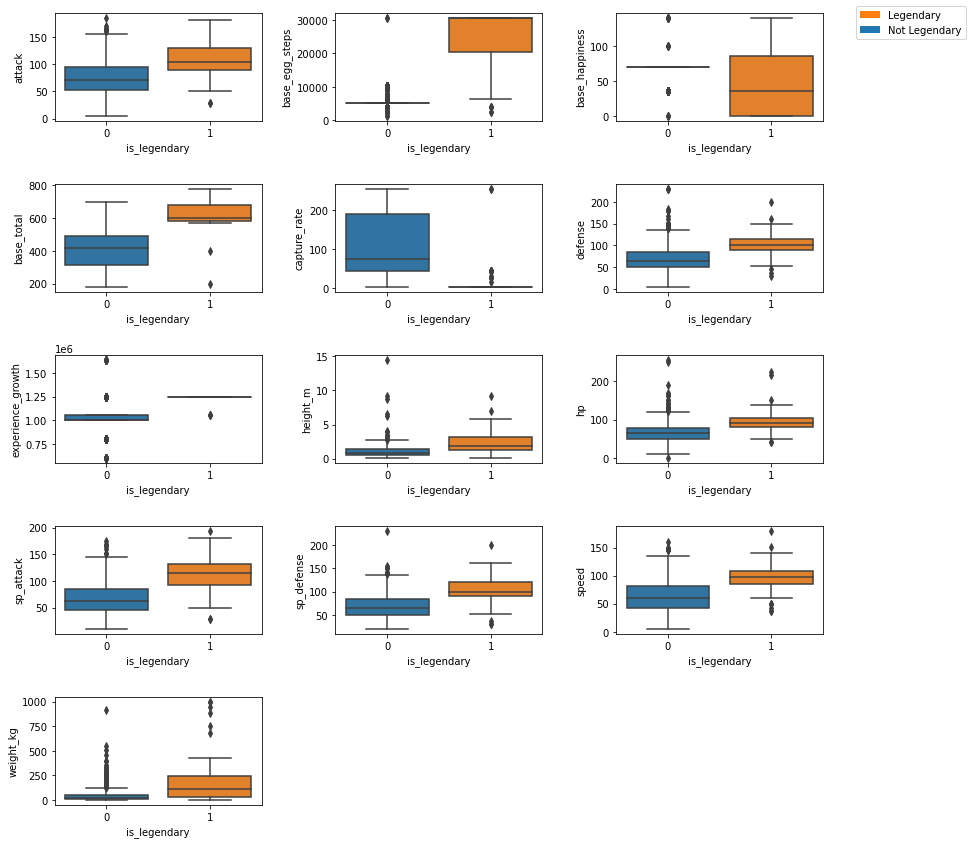

In [7]:
fig, axs = plt.subplots(5, 3, figsize=(12,12))

cols = ['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg']


for var, ax in zip(cols, list(itertools.chain(*axs))):
    # box & whisker
    sns.boxplot(data=df, x="is_legendary", y=var, ax=ax)
    
#     # histogram w or w/o kde
#     sns.histplot(data=df, x=var, multiple='stack', kde=True, hue='is_legendary', alpha=0.5, ax=ax, legend=False)


legend_elements = [Patch(facecolor='tab:orange', label='Legendary'), Patch(facecolor='tab:blue', label='Not Legendary')]

fig.legend(handles=legend_elements, bbox_to_anchor=(1,0.99), loc="upper left")
fig.tight_layout(pad=2)
fig.delaxes(axs[-1][-1]); fig.delaxes(axs[-1][-2])
plt.show()

As one would expect, it seems that Pokemon with higher combat statistics such as `hp`, `attack`, `defense`, `speed` are more likely to be classed as legendary, and a similar split is observed for Pokemon with low capture rate.

Interestingly, we can achieve adequate separation with just two features, namely, `caputure_rate` and `base_egg_steps`, as evidenced by the scatter plot below.

C:\Users\Harrison\AppData\Local\Temp/ipykernel_4284/3345324444.py:6: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x0000018251E597F0> has a label of '_hidden' which cannot be automatically added to the legend.
  plt.legend(['_hidden', 'Non-Legendary', 'Legendary'], bbox_to_anchor=(1,1.025), loc="upper left")


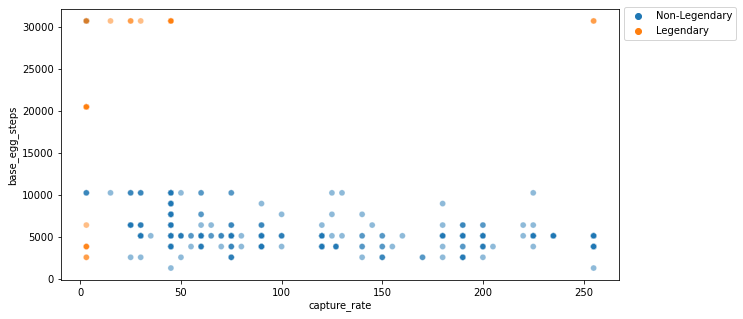

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

sc = sns.scatterplot(x=df['capture_rate'], y=df['base_egg_steps'], hue=df['is_legendary'], ax=ax, alpha=0.5)

# ignore error below, there's some issue with items in the legend appearing without permission
plt.legend(['_hidden', 'Non-Legendary', 'Legendary'], bbox_to_anchor=(1,1.025), loc="upper left")
plt.show()

Many non-linear classifiers should be able to create a decision function which can separate these two classes, but first let's define our input features and target variable, then split the data into training and testing sets. We'll use stratification to ensure that the legendaries are equally distributed across both datasets.

In [9]:
X = df.loc[:,['capture_rate','base_egg_steps', 'is_legendary']].copy(deep=True)
y = X.pop('is_legendary')

# split into stratified training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

Our pipeline will consist of a scaler and a classifier, namely, the `MinMaxScaler` and support vector classifier `SVC` from the scikit-learn library.

We'll use `GridSearchCV` to find optimal parameters for the SVC. Note the use of the rbf, or Gaussian kernel, which is necessary to create the non-linear decision boundary required to separate the two classes.

In [10]:
pipe = Pipeline([('scaler', None), ('clf', SVC())])

params = {
  'scaler': [MinMaxScaler()],
  'clf__C': [10**x for x in [-2,-1,0,1,2,]],
  'clf__gamma': [1, 0.5, 0.25, 0.1, 0.05],
  'clf__kernel': ['rbf'],
  'clf__class_weight': [None, 'balanced']
  }
  
grid = GridSearchCV(pipe, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.score(X_test, y_test)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Best parameters: {'clf__C': 100, 'clf__class_weight': None, 'clf__gamma': 1, 'clf__kernel': 'rbf', 'scaler': MinMaxScaler()}
Best score: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


Our classifier achieves a perfect score here, which is not too surprising given how well separated the two classes are on the previous plot. Given the low dimensionality of the data, it is also possible to superimpose the decision boundary from the SVM and see how different regions of the feature space are classified.

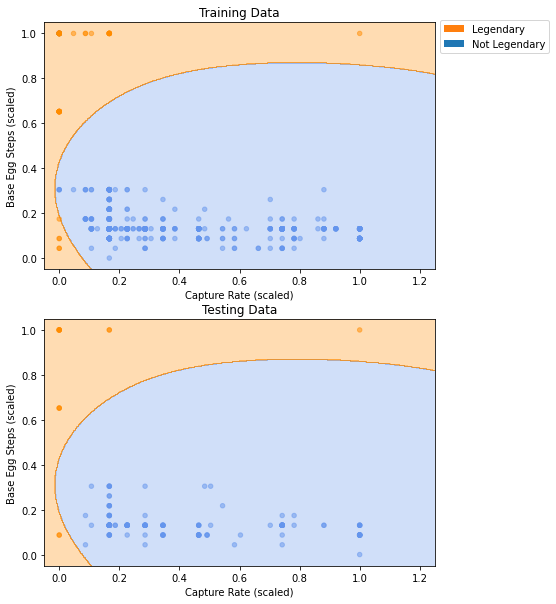

In [11]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["cornflowerblue", "darkorange"])

# decision boundary plot taken from:
# https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

def make_meshgrid(x, y, h=.0025):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, [ax1, ax2] = plt.subplots(2,1, figsize=(7,10))

for ax, X, y, title in zip([ax1, ax2], [X_train, X_test], [y_train, y_test], ['Training Data', 'Testing Data']):

    X_scaled = grid.best_estimator_.steps[0][1].transform(X)

    X0, X1 = X_scaled[:, 0], X_scaled[:, 1]

    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, grid.best_estimator_.steps[1][1], xx, yy, cmap=cmap, alpha=0.3)

    ax.scatter(X0, X1, c=y, cmap=cmap, s=20, alpha=0.5)

    ax.set_ylabel('Base Egg Steps (scaled)')
    ax.set_xlabel('Capture Rate (scaled)')
    ax.set_xlim([-0.05,1.25])
    ax.set_ylim([-0.05,1.05])
    ax.set_title(title)

fig.legend(handles=legend_elements, bbox_to_anchor=(0.9,0.89), loc="upper left")
plt.show()

### Comments

Note that the decision function depends on how the data is split, as it appears possible to obtain X_train such that not enough legendaries are present in the smaller clusters (near the origin, or near (1,1)). Such a scenario could lead to a decision boundary that does not cover that region, resulting in misclassification. One approach which could reduce the likelihood of this happening, would be to generate synthetic data to boost the number of examples in the minority class, thus reducing the probability of excluding the smaller clusters from the training set. One of the many flavours of SMOTE might do the trick: https://imbalanced-learn.org/dev/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py.